## Heating Data Profile Extraction for HPZ Building

This notebook will extract typical profiles from the HPZ Heating meter for use as input for the coupled co-simulation with CitySim

In [136]:
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [137]:
%matplotlib inline 

In [138]:
workingdir = "/Users/Clayton/Dropbox/03-ETH/98-UMEM/RawDataAnalysis"

In [139]:
# os.chdir(workingdir)

In [140]:
df_QW = pd.read_csv(workingdir+"/aggset2_QW/HPZ_QW.csv", index_col="Date Time", parse_dates=True)

In [141]:
point = "HPZMKA96QW_A [kWh]"

In [142]:
df_QW = pd.read_csv(workingdir+"/aggset2_QW/HPZ_QW.csv", index_col="Date Time", parse_dates=True)

In [147]:
df_QW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2013-01-01 00:00:00 to 2014-01-01 00:00:00
Data columns (total 1 columns):
HPZMKA96QW_A [kWh]    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [144]:
df_QW = pd.DataFrame(df_QW[point].truncate(before='2013',after='2014'))

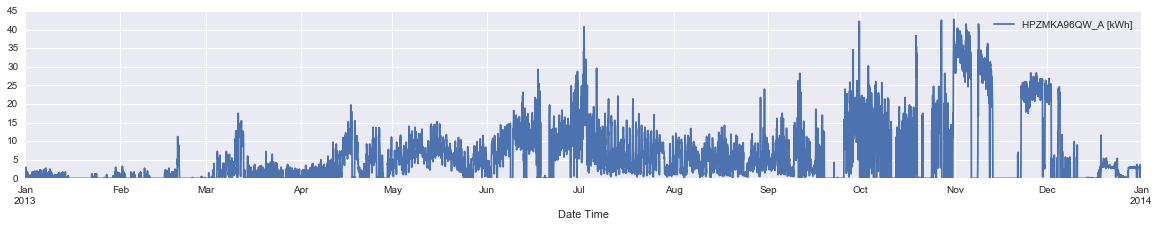

In [145]:
df_QW.plot(figsize=(20,3));

## Convert to SAX

In [60]:
df = df_QW.dropna()

In [61]:
#df.head()

In [62]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [63]:
df_pivot = pd.pivot_table(df, values=point, index='Date', columns='Time')

In [64]:
a = 3
w = '4h'

In [65]:
from scipy.stats import norm
import numpy as np
import string

In [66]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [67]:
df_forSAX = df[point]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

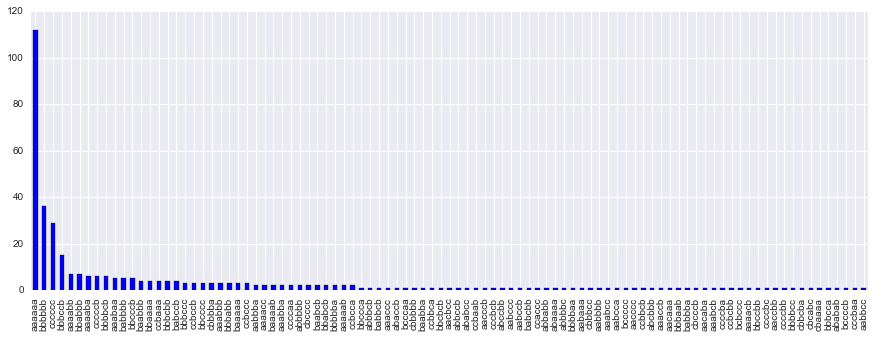

In [68]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [69]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

aaaaaa    112
bbbbbb     36
cccccc     29
bbbccb     15
dtype: int64

In [70]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords.head()

aaaabb    7
bbabbb    7
aaaaba    6
cccccb    6
bbbbcb    6
dtype: int64

In [71]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [72]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

# Cluster!

In [73]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [74]:
# df = motifdata.drop(['SAXstring'], axis=1)

In [75]:
df_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.75,0.00,0.75,3.00,0.0,1.25,1.25,0.00,0.00,0,...,0.00,1,1.75,0.00,0.25,0.0,0,0.25,0,1.00
2013-01-02,0.00,0.00,0.50,0.75,0.5,0.25,0.75,0.75,0.00,0,...,0.00,0,0.75,0.00,0.00,0.0,0,0.00,0,1.00
2013-01-03,1.00,0.25,0.00,0.00,0.0,1.75,0.00,0.00,0.00,0,...,0.00,0,0.75,1.75,0.00,0.0,0,1.00,0,0.75
2013-01-04,0.50,2.00,1.25,1.50,0.5,0.25,0.25,0.00,0.00,0,...,1.00,0,1.25,1.25,2.00,1.5,0,0.50,1,0.00
2013-01-05,1.00,1.75,1.00,0.00,1.0,0.00,1.50,1.50,1.25,0,...,0.25,1,0.75,2.25,0.00,1.5,0,0.00,0,1.75


In [76]:
df = df_pivot

In [77]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [78]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.Time)
df.index = df.timestampstring
df = df.drop(['Date','Time','timestampstring'],axis=1)
df.columns = [point]
df = df.resample('H')

In [79]:
df.head()

,HPZMKA96QW_A [kWh]
timestampstring,
2013-01-01 00:00:00,1.75
2013-01-01 01:00:00,0.00
2013-01-01 02:00:00,0.75
2013-01-01 03:00:00,3.00
2013-01-01 04:00:00,0.00


In [80]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [81]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [82]:
dailyblocks = pd.pivot_table(df, values=point, index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values=point, index='Date', columns='Time', aggfunc='mean')

In [83]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [84]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [85]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [86]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


In [87]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


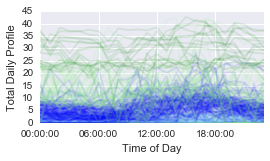

In [88]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 4,2

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 21600))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("cooling_clusters_total_overlaid_profiles.pdf")

In [94]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.Time)
    df = df.dropna()
    return df

In [95]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [96]:
#df

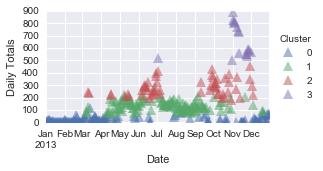

In [97]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=10, alpha=0.5)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("cooling_clusters_overtime.pdf")

In [98]:
dailyclusters.head()

ClusterNo2          0                                                         \
Date       2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06   
Time                                                                           
00:00:00         1.75       0.00       1.00       0.50       1.00       2.25   
01:00:00         0.00       0.00       0.25       2.00       1.75       1.00   
02:00:00         0.75       0.50       0.00       1.25       1.00       1.50   
03:00:00         3.00       0.75       0.00       1.50       0.00       0.00   
04:00:00         0.00       0.50       0.00       0.50       1.00       0.75   

ClusterNo2                                                ...              3  \
Date       2013-01-07 2013-01-08 2013-01-09 2013-01-10    ...     2013-11-10   
Time                                                      ...                  
00:00:00         0.50        1.0       0.25       0.75    ...         31.250   
01:00:00         0.75        0.5       0.25       0.75    ...         30.250   
02:00:00         1.25        1.5       0.50       0.50    ...         31.000   
03:00:00         0.75        0.5       0.00       0.00    ...         25.625   
04:00:00         0.00        0.5       0.50       0.75    ...         30.125   

ClusterNo2                                                                    \
Date       2013-11-11 2013-11-12 2013-11-23 2013-11-24 2013-11-25 2013-11-26   
Time                                                                           
00:00:00       30.625     28.125     22.750     21.500     22.500     23.875   
01:00:00       29.125     27.750     22.625     21.375     21.375     22.750   
02:00:00       29.500     28.000     23.625     25.375     20.500     21.750   
03:00:00       24.000     20.250     25.750     23.875     22.250     23.125   
04:00:00       29.125     27.750     22.875     23.375     22.000     26.750   

ClusterNo2                                   
Date       2013-11-27 2013-11-28 2013-12-01  
Time                                         
00:00:00       25.000     24.875     24.000  
01:00:00       23.750     23.500     21.625  
02:00:00       20.750     22.875     23.750  
03:00:00       24.875     23.250     24.500  
04:00:00       23.500     24.875     24.125  

[5 rows x 364 columns]

In [99]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2,0,1,2,3
timestampstring,,,,
2013-01-01,14.50,NaN,NaN,NaN
2013-01-02,6.00,NaN,NaN,NaN
2013-01-03,9.00,NaN,NaN,NaN
2013-01-04,17.00,NaN,NaN,NaN
2013-01-05,20.75,NaN,NaN,NaN


In [100]:
calendar.to_csv("cooling_calendar.csv")

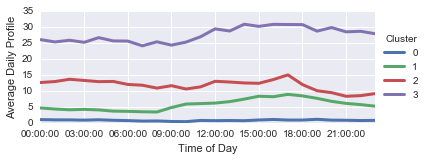

In [101]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(6,2),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("cooling_clusters_averagedprofiles.pdf")

In [102]:
dfclusterunstackedpivoted.groupby('Time').max().max().max()

42.75000000864382

In [103]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / (dfclusterunstackedpivoted.groupby('Time').max().max().max()*0.7)

In [104]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles.head()

ClusterNo2,0,1,2,3
Time,,,,
00:00:00,0.033668,0.155298,0.422176,0.871624
01:00:00,0.030857,0.144353,0.432403,0.847489
02:00:00,0.030726,0.136582,0.456313,0.865358
03:00:00,0.027941,0.140824,0.443998,0.843312
04:00:00,0.031934,0.135125,0.431323,0.892509


In [105]:
normalizedprofiles.to_csv("cooling_schedules.csv")

In [106]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

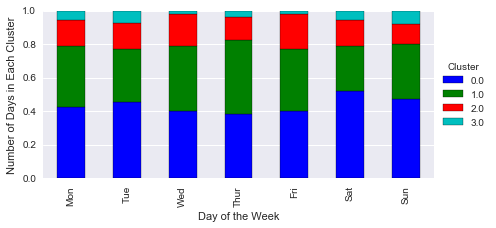

In [107]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsCluster = DayVsCluster.T/DayVsCluster.T.sum()
DayVsCluster = DayVsCluster.T
DayVsClusterplot1 = DayVsCluster.plot(figsize=(7,3), kind='bar', stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("cooling_clusters_dailybreakdown.png")

In [108]:
DayVsCluster

ClusterNo2,0.0,1.0,2.0,3.0
Mon,0.423077,0.365385,0.153846,0.057692
Tue,0.452830,0.320755,0.150943,0.075472
Wed,0.403846,0.384615,0.192308,0.019231
Thur,0.384615,0.442308,0.134615,0.038462
Fri,0.403846,0.365385,0.211538,0.019231
Sat,0.519231,0.269231,0.153846,0.057692
Sun,0.470588,0.333333,0.117647,0.078431


## Create Graphics for JBPS Paper

First load the resultant data from the analysis so no need to rerun:

In [111]:
normalizedprofiles = pd.read_csv("cooling_schedules.csv", index_col='Time')

In [112]:
normalizedprofiles.head()

,0,1,2,3
Time,,,,
00:00:00,0.033668,0.155298,0.422176,0.871624
01:00:00,0.030857,0.144353,0.432403,0.847489
02:00:00,0.030726,0.136582,0.456313,0.865358
03:00:00,0.027941,0.140824,0.443998,0.843312
04:00:00,0.031934,0.135125,0.431323,0.892509


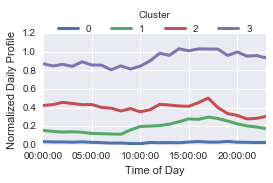

In [113]:
dailyprofile = normalizedprofiles.plot(figsize=(4,2),linewidth=3)
dailyprofile.set_ylabel('Normalized Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title='Cluster', ncol=4)
plt.savefig("cooling_clusters_averagedprofiles_normalized.pdf")

###The Cal-Heatmap setup

In [114]:
calendar = pd.read_csv("cooling_calendar.csv", index_col='timestampstring', parse_dates=True)

In [115]:
#calendar.fillna(0).dropna(how="all").info()

In [116]:
import time

In [117]:
calendar['epochtime'] = calendar.index.map(lambda x: int(time.mktime(x.timetuple())))
calendar.index = calendar.epochtime

In [118]:
calendar.head()

,0,1,2,3,epochtime
epochtime,,,,,
1356969600,14.50,NaN,NaN,NaN,1356969600
1357056000,6.00,NaN,NaN,NaN,1357056000
1357142400,9.00,NaN,NaN,NaN,1357142400
1357228800,17.00,NaN,NaN,NaN,1357228800
1357315200,20.75,NaN,NaN,NaN,1357315200


In [119]:
calendar = calendar.drop(['epochtime'], axis=1)

In [120]:
calendar.head()

,0,1,2,3
epochtime,,,,
1356969600,14.50,NaN,NaN,NaN
1357056000,6.00,NaN,NaN,NaN
1357142400,9.00,NaN,NaN,NaN
1357228800,17.00,NaN,NaN,NaN
1357315200,20.75,NaN,NaN,NaN


In [121]:
cal_heatmap = calendar.unstack().dropna().reset_index()

In [122]:
cal_heatmap.head()

,level_0,epochtime,0
0,0,1356969600,14.50
1,0,1357056000,6.00
2,0,1357142400,9.00
3,0,1357228800,17.00
4,0,1357315200,20.75


In [123]:
cal_heatmap.index = cal_heatmap.epochtime

In [124]:
cal_heatmap.head()

,level_0,epochtime,0
epochtime,,,
1356969600,0,1356969600,14.50
1357056000,0,1357056000,6.00
1357142400,0,1357142400,9.00
1357228800,0,1357228800,17.00
1357315200,0,1357315200,20.75


In [125]:
cal_heatmap = cal_heatmap.drop(['epochtime',0], axis=1)

In [126]:
cal_heatmap = cal_heatmap.sort()

/Users/Clayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


In [127]:
cal_heatmap.level_0 = cal_heatmap.level_0.astype("float")

In [128]:
cal_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1356969600 to 1388419200
Data columns (total 1 columns):
level_0    364 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [129]:
cal_heatmap.head()

,level_0
epochtime,
1356969600,0
1357056000,0
1357142400,0
1357228800,0
1357315200,0


In [130]:
cal_heatmap = cal_heatmap+1

In [131]:
cal_heatmap.head()

,level_0
epochtime,
1356969600,1
1357056000,1
1357142400,1
1357228800,1
1357315200,1


In [132]:
cal_heatmap.level_0.to_json("hpz_cal_heatmap.json")

In [133]:
x = sns.color_palette()

/Users/Clayton/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [134]:
import matplotlib.colors as colors

In [135]:
for color in x:
    print colors.rgb2hex(color)

#4c72b0
#55a868
#c44e52
#8172b2
#ccb974
#64b5cd
